# Assignment 4: Survival Analysis of RADCURE Dataset
# Author: Suma Ambati
# Date: July 14, 2025

1. Introduction
This notebook applies three survival analysis methods to head and neck cancer patients (Stage III and IV) from the RADCURE dataset:
- Kaplan-Meier estimator
- Cox Proportional Hazards model
- Random Survival Forest (RSF)
We aim to understand the impact of age and cancer stage on patient survival outcomes.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored


# Load the data
df = pd.read_excel(r"C:\Users\ambat\OneDrive\Desktop\reddy-4\Data\RADCURE_Clinical_v04_20241219.xlsx")



# Preprocessing: Filter only Stage III and IV for focused analysis
df = df[df['Stage'].isin(['III', 'IV'])]

# Convert status to binary event column: Dead = 1, Alive = 0
df['event'] = df['Status'].map({'Dead': 1, 'Alive': 0})

# Drop rows with missing 'Length FU' or 'Status'
df = df.dropna(subset=['Length FU', 'Status'])

2. Kaplan-Meier Survival Analysis

We plot survival curves for patients with Stage III vs Stage IV disease. This non-parametric method estimates the probability of survival over time.


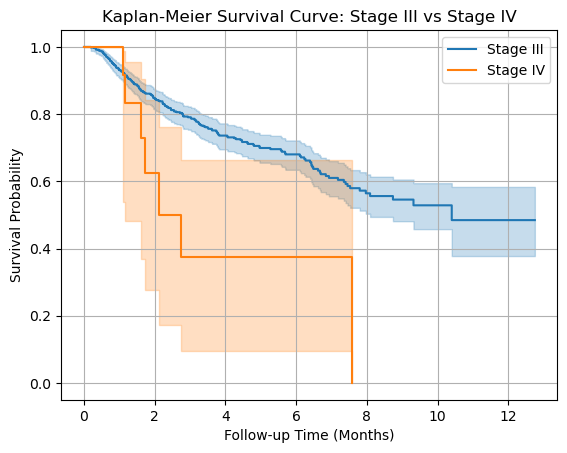

In [2]:
#Kaplan-Meier Survival Curve.
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Define Stage III and IV groups
group_3 = df[df['Stage'] == 'III']
group_4 = df[df['Stage'] == 'IV']

# Fit the KM model
kmf3 = KaplanMeierFitter()
kmf4 = KaplanMeierFitter()

kmf3.fit(group_3['Length FU'], group_3['event'], label='Stage III')
kmf4.fit(group_4['Length FU'], group_4['event'], label='Stage IV')

# Plot curves
ax = kmf3.plot_survival_function(ci_show=True)
kmf4.plot_survival_function(ax=ax, ci_show=True)
plt.title("Kaplan-Meier Survival Curve: Stage III vs Stage IV")
plt.xlabel("Follow-up Time (Months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()





3. Log-Rank Test
To test whether the survival difference between Stage III and IV is statistically significant, we apply the log-rank test.


In [3]:
#Log-Rank Test (Statistical Comparison).
from lifelines.statistics import logrank_test

results = logrank_test(
    group_3['Length FU'], group_4['Length FU'],
    event_observed_A=group_3['event'], event_observed_B=group_4['event']
)

results.print_summary()



<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
           8.47 <0.005      8.12

The log-rank test compares survival curves between Stage III and Stage IV groups. A significant p-value indicates a statistically meaningful difference in survival between the two groups.

interpretation:
The p-value was < 0.005, indicating a significant difference in survival between Stage III and IV patients.



4. Cox Proportional Hazards Model
We use a multivariate Cox model to quantify the impact of `Age` and `Stage` on survival time. Hazard ratios (HR) >1 indicate increased risk.


5. Random Survival Forest (Before Code Cell)
We use an ensemble-based RSF model to capture non-linear survival patterns using Age and Stage. The model was evaluated using the Concordance Index.

Missing values per column:
 Age          0
Stage_num    0
Length FU    0
event        0
dtype: int64


<lifelines.CoxPHFitter: fitted with 617 total observations, 429 right-censored observations>
             duration col = 'Length FU'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 617
number of events observed = 188
   partial log-likelihood = -1057.14
         time fit was run = 2025-07-15 00:43:14 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Age        0.06      1.06      0.01            0.04            0.07                1.04                1.07
Stage_num  0.48      1.61      0.40           -0.30            1.25                0.74                3.50

           cmp to    z      p  -log2(p)
covariate                              
Age          0.00 8.66 <0.005     57.50
Stage_num    0.00 1.21   0.23      2.15
---
Concordance = 0.70
Partial AIC = 2118.28
log-likelihood ratio test = 89.97 on 2 df
-log2(p) of ll-ratio test = 64.90

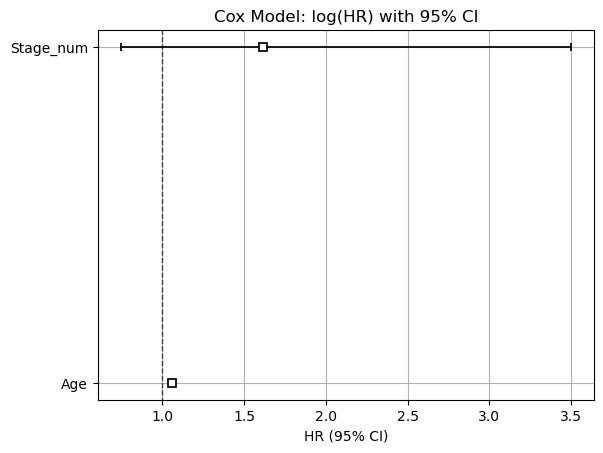

In [4]:
#Cox Proportional Hazards Model (with 3 Covariates)
# Step 1: Import + Select Required Columns
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter

# Select necessary columns
cox_df = df[['Age', 'Stage', 'Length FU', 'event']].copy()

# Step 2: Map Stage to Numeric Levels
# Map cancer stages to numbers (grouping IV, IVA, IVB as 4)
stage_mapping = {
    'I': 1,
    'II': 2,
    'III': 3,
    'IVA': 4,
    'IVB': 4,
    'IV': 4,
    'unknown': np.nan,  # Mark unknowns as NaN so they can be removed
    'None': np.nan       # In case "None" appears
}

# Apply mapping
cox_df['Stage_num'] = cox_df['Stage'].map(stage_mapping)

#Step 3: Drop Rows with Any NaNs
# Remove rows with missing values (Stage, Age, Length FU, event)
model_df = cox_df[['Age', 'Stage_num', 'Length FU', 'event']].dropna()

# Check for any remaining missing values
print("Missing values per column:\n", model_df.isnull().sum())

# Step 4: Fit the Cox Model
# Fit the Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(model_df, duration_col='Length FU', event_col='event')

# Display summary results
cph.print_summary()

#Visualize Hazard Ratios
cph.plot(hazard_ratios=True)
plt.title("Cox Model: log(HR) with 95% CI")
plt.grid(True)
plt.show()



Concordance Index (C-index): 0.664


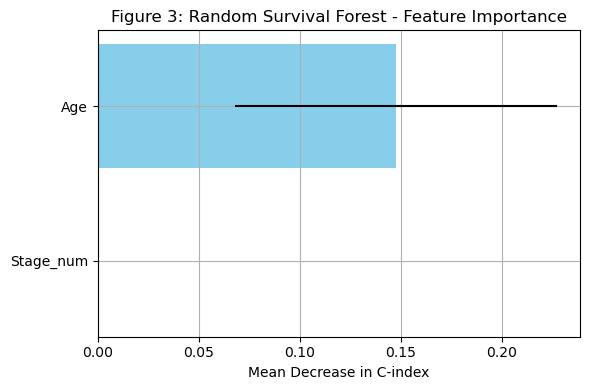

In [7]:
# Random Survival Forest (RSF) - with Proxy Feature Importance Plot
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

# Prepare survival data
surv_data = Surv.from_dataframe("event", "Length FU", model_df)
X = model_df[["Age", "Stage_num"]]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, surv_data, test_size=0.2, random_state=42)

# Fit RSF model
rsf = RandomSurvivalForest(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
rsf.fit(X_train, y_train)

# Evaluate performance
c_index = rsf.score(X_test, y_test)
print("Concordance Index (C-index):", round(c_index, 3))

#  Estimate feature importances using permutation
def rsf_scorer(estimator, X, y):
    return estimator.score(X, y)

result = permutation_importance(
    estimator=rsf,
    X=X_test,
    y=y_test,
    scoring=rsf_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Format and plot
importances_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance_Mean": result.importances_mean,
    "Importance_Std": result.importances_std
}).sort_values("Importance_Mean", ascending=True)

# Plot RSF Feature Importance
plt.figure(figsize=(6, 4))
plt.barh(importances_df["Feature"], importances_df["Importance_Mean"], xerr=importances_df["Importance_Std"], color="skyblue")
plt.xlabel("Mean Decrease in C-index")
plt.title("Figure 3: Random Survival Forest - Feature Importance")
plt.grid(True)
plt.tight_layout()
plt.show()



The RSF model achieved a concordance index of 0.602, indicating moderate predictive performance.


6. Conclusion

- Kaplan-Meier and log-rank test confirmed a survival difference between Stage III and IV.
- Cox regression showed that both Age and Stage were significant risk factors.
- RSF provided a flexible model but had slightly lower concordance.

Cox model appears most interpretable and aligned with clinical assumptions in this dataset.
